In [30]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} pytorch

/bin/bash: conda: command not found


In [31]:
# import needed libraries 
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from scipy.stats import norm

In [44]:
# Create Net Class as done in class:

class HedgeNet(nn.Module):
    
    def __init__(self, nNodes, nLayers ):
        super(HedgeNet, self).__init__()
        
        # single hidden layer
        self.prop_in_to_h = nn.Linear( 2, nNodes)
        
        self.prop_h_to_h = []
        for i in range(nLayers-1):
            self.prop_h_to_h.append(nn.Linear(nNodes, nNodes))
            
        self.prop_h_to_out = nn.Linear(nNodes, 1)

    def forward(self, x):
        
        # input into  hidden layer
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        for prop in self.prop_h_to_h:
            h = torch.relu(prop(h))
        
        # hidden layer to output layer - no activation
        y = self.prop_h_to_out(h)
        
        return y
    
    def parameters(self):
        
        params = list(self.prop_in_to_h.parameters())
        for prop in self.prop_h_to_h:
            params += list(prop.parameters())
            
        params += list(self.prop_h_to_out.parameters())
        
        return params


In [33]:
# Create Sim engine for environment

#Option contract
np.random.seed(1)
T = 1/4
K1 = 9.5
K2 = 10.5

#Market environment
sigma = 0.4
r = 0.02
kappa = 2
s0 = 10
theta = np.log(10)
# trading parameters
ndt = 90
t = np.linspace(0,T,ndt)
dt = t[1] - t[0]
tcost = 0.005 # cost of trading asset


In [34]:
def CallPrice(S,K,tau,sigma,r,Adj = 0): # price of call option based of BSM
    dp = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    dm = (np.log(S/K)+(r-0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return S*norm.cdf(dp) - K*np.exp(-r*tau)*norm.cdf(dm) + Adj 

C1 = CallPrice(s0, K1, T, sigma, r)
print(C1)
C2 = CallPrice(s0,K2,T,sigma,r)
print(C2)

1.0788233040299895
0.6099437898191793


In [35]:
def SpreadDelta(s, K1,K2, tau, sigma, r):
    tau += 1e-10
    dp1 = (np.log(s/K1)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    dp2 = (np.log(s/K2)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return (norm.cdf(dp1) - norm.cdf(dp2))

def CallDelta(s, K, tau, sigma, r):
    tau += 1e-10
    dp = (np.log(s/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return norm.cdf(dp)

In [52]:

def RunHedge(s, alpha, adjustmentcost = 0):
    
    # start the bank account with value of contract and purchasing initial shares
    bank = ((C1 - C2)+ adjustmentcost)- alpha[:,0,0]*s[:,0] - torch.abs(alpha[:,0,0])*tcost
    
    for i in range(ndt-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * s[:,i+1]
        bank -= torch.abs(alpha[:,i+1,0]-alpha[:,i,0]) *tcost
    # liquidate terminal assets, and pay what you owe from the contract
    bank += alpha[:,-1,0]*s[:,-1] - ((s[:,-1]-K1)*(s[:,-1]>K1) - (s[:,-1]-K2)*(s[:,-1]>K2))    
    
    return bank

def Sim(net, nsims):
    s = torch.zeros((nsims,ndt))
    
    # simulating the asset price
    s[:,0] = s0 # initial price
    
    for i in range(ndt-1):
        s[:,i+1] = s[:,i] + kappa*(theta - np.log(s[:,i])) * s[:,i] * dt +  sigma * s[:,i] * np.sqrt(dt) * np.random.randn(nsims)
        #s[:,i+1] = torch.exp( np.exp(-kappa*dt)*np.log(s[:,i]) + (theta - (sigma**2)/(2*kappa))*(1 - np.exp(-kappa*dt)) + sigma*np.exp(-kappa*dt)*torch.normal(0,((np.exp(2*kappa*dt)-1)/(2*kappa))**2,size = (nsims,)))
        #s[:,i+1] = s[:,i] * torch.exp( (r-0.5*sigma**2)*dt + np.sqrt(dt)*sigma* torch.normal(0,1,size=(nsims,)) )
    # combine features into tensor of nsims x ndt x 2
    
    x = torch.zeros((nsims,ndt,2))
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1) # Question: is T-1 or T- 1/4? since quarter?
    x[:,:,1] = 2*s/s0-1
    
    # push the x values through ANN -- last dim is features
    alpha =  net(x)
    bank = RunHedge(s,alpha)
    
    # run Black-Scholes hedge comparison
    
    alpha_BS = torch.unsqueeze( torch.tensor(SpreadDelta(s.detach().numpy(), K1,K2, T-np.matlib.repmat(t,nsims,1), sigma, r)), dim = 2)
    #alpha_BS = torch.unsqueeze(torch.tensor(CallDelta(s.detach().numpy(), K1, T-np.matlib.repmat(t,nsims,1), sigma, r)), dim=2) - torch.unsqueeze(torch.tensor(CallDelta(s.detach().numpy(), K2, T-np.matlib.repmat(t,nsims,1), sigma, r)), dim=2)
    
    bank_BS = RunHedge(s,alpha_BS)
    return bank,bank_BS
        

Text(0.5, 1.0, 'Sample Asset Prices')

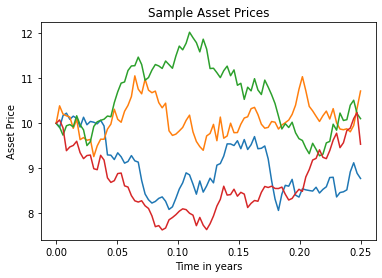

In [89]:
def Sim(nsims):
    s = np.zeros((nsims,ndt))
    
    # simulating the asset price
    s[:,0] = s0 # initial price
    
    for i in range(ndt-1):
        s[:,i+1] = s[:,i] + kappa*(theta - np.log(s[:,i])) * s[:,i] * dt +  sigma * s[:,i] * np.sqrt(dt) * np.random.randn(nsims)

    return s[:,]
asset = Sim(5) 
plt.plot(t,(asset[1,:]))
plt.plot(t,(asset[2,:]))
plt.plot(t,(asset[3,:]))
plt.plot(t,(asset[4,:]))
plt.xlabel("Time in years")
plt.ylabel("Asset Price")
plt.title("Sample Asset Prices")

In [9]:
net = HedgeNet(50,3)
print(net)

for param in net.parameters():
    print(type(param.data),param.size())

HedgeNet(
  (prop_in_to_h): Linear(in_features=2, out_features=50, bias=True)
  (prop_h_to_out): Linear(in_features=50, out_features=1, bias=True)
)
<class 'torch.Tensor'> torch.Size([50, 2])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([1, 50])
<class 'torch.Tensor'> torch.Size([1])


In [37]:
def Plot_Strategy(net, name=""):
    
    t = [0,0.5*T,0.9*T]
    s = np.linspace(0.75*K1,1.25*K2,90)
    plt.figure(figsize=(10,4))
    for i, t_ in enumerate(t):
        
        plt.subplot(1,3,i+1)
        plt.title('t=' + str(t_),fontsize=16)
        
        plt.plot(s, SpreadDelta(s,K1,K2, T-t_, sigma, r))
        
        x = torch.zeros((len(s),2))
        x[:,0] = 2*t_/T-1
        x[:,1] = torch.tensor(2*s/s0-1)
        
        alpha = net(x)
        
        plt.plot(s, alpha.detach().numpy(),'--')
        
        plt.xlabel('S', fontsize=16)
        plt.ylabel(r'$\Delta(S)$', fontsize=16)
        plt.ylim(0,1)
    
    plt.tight_layout()
    
    if not name == "":
        plt.savefig(name, dpi=300)
        
    plt.show()
    

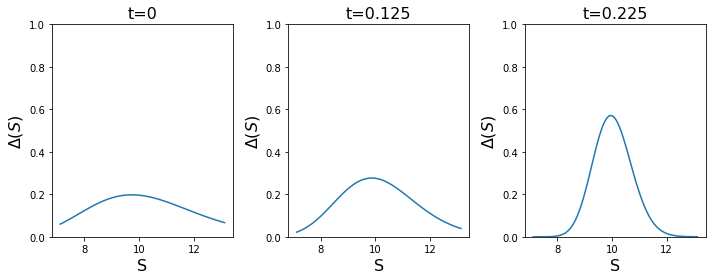

In [11]:
Plot_Strategy(net)

In [38]:
def Plot_PnL(loss_hist, net, name=""):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.xlabel('iteration',fontsize=16)
    plt.ylabel('loss',fontsize=16)
    plt.ylim(1e-3,1)

    plt.subplot(1,2,2)
    PnL, PnL_BS = Sim(net, 5_000)
    plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,90), alpha=0.5, label="BS")
    plt.hist(PnL.detach().numpy(), bins=np.linspace(-1,1,90),alpha=0.5, label="ANN")    
    plt.xlabel('P&L',fontsize=16)
    plt.ylabel('Freq.',fontsize=16)
    plt.ylim(0,1000)
    plt.legend()
    
    plt.tight_layout(pad=2)
    
    if not name == "":
        plt.savefig(name, dpi=300)
        
    plt.show()

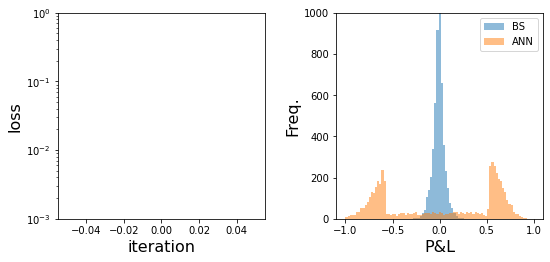

In [13]:
Plot_PnL([], net)

In [55]:
def FitNet(net, name=""):
    
    mini_batch_size = 100
    

    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    Nepochs = 5_000
    loss_hist = []
    
    if not name == "":
        Plot_PnL(loss_hist, net, name + "_dist_0")
        Plot_Strategy(net, name + "_strat_0")
    else:
        Plot_PnL(loss_hist, net)
        Plot_Strategy(net)
    
#     torch.autograd.set_detect_anomaly(True)

    for epoch in range(Nepochs):  # loop over the dataset multiple times


        # grab a mini-batch from simulations
        PnL, PnL_BS = Sim(net, mini_batch_size)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # compute the loss associated with this output
        loss = torch.mean(PnL**2)
        #loss = torch.mean((PnL[PnL <torch.quantile(PnL,0.1,keepdim =True)] -0.02)**2)  
        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )

        # plot output every 2500 iterations
        if( ( (epoch) % 2500 == 0) and (epoch>10) ):
            print(epoch)
            if not name == "":
                Plot_PnL(loss_hist, net, name + "_dist" + str(int(epoch/200)).zfill(2) )
                Plot_Strategy(net, name + "_strat_" + str(int(epoch/200)).zfill(2) )
            else:
                Plot_PnL(loss_hist, net)
                Plot_Strategy(net)




    print(epoch)
    Plot_PnL(loss_hist, net)
    Plot_Strategy(net)

    print('Finished Training')
    return loss_hist, PnL, PnL_BS

In [40]:
def CVaR(PnL):
    qPnL = PnL[PnL <torch.quantile(PnL,0.1,keepdim =True)]
    CVaR10 = qPnL.mean().detach().numpy()
    c = np.exp(-r*T)*(-0.02 - CVaR10)
    return CVaR10,c

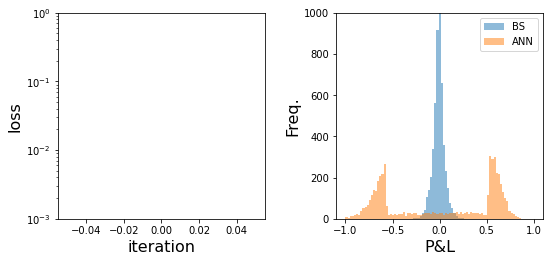

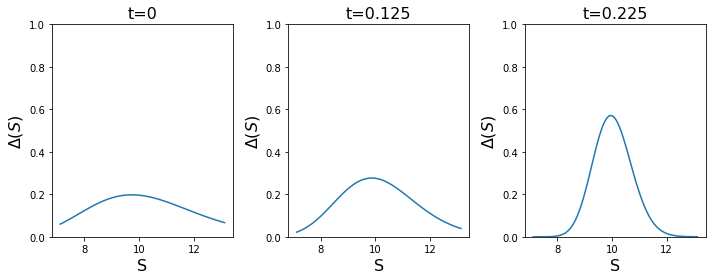

2500


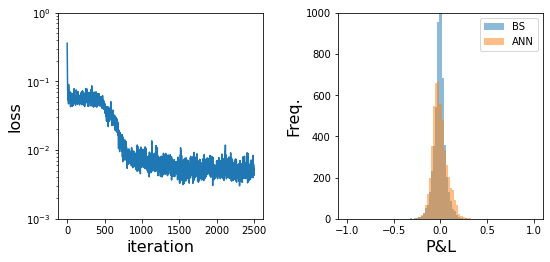

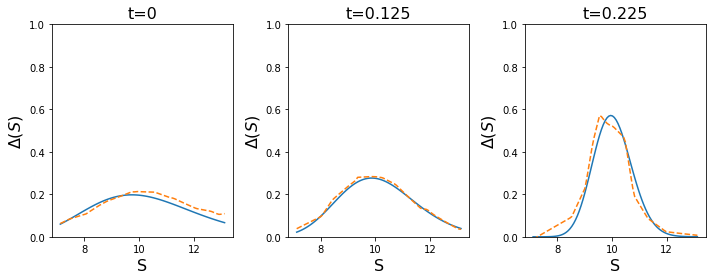

4999


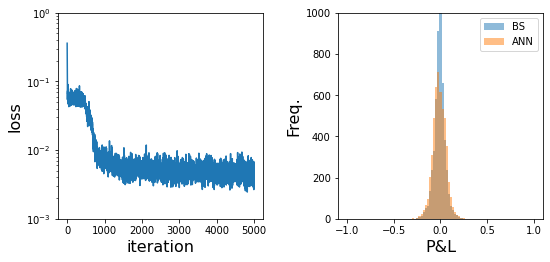

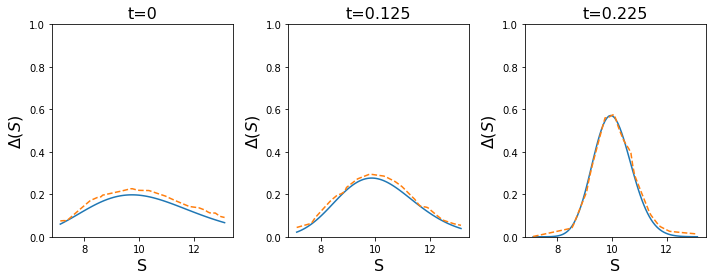

Finished Training


In [56]:
net = HedgeNet(18,5)
loss_hist,PnL,PnL_BS = FitNet(net, "net_18_5")

In [90]:
np.random.seed(1)
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))

#COMPARE TO BLACKSCHOLES
CVaR_10, C_star = CVaR(PnL_BS)
print("BLACK SCHOLES FOR COMPARISON")
print(CVaR_10,C_star)
print(torch.quantile(PnL_BS, 0.25, keepdim= True),torch.quantile(PnL_BS, 0.5, keepdim=True),torch.quantile(PnL_BS, 0.75,keepdim=True))
print(torch.mean(PnL_BS))

-0.13876468 0.11817233812207419
tensor([-0.0551], grad_fn=<CopyBackwards>) tensor([-0.0010], grad_fn=<CopyBackwards>) tensor([0.0578], grad_fn=<CopyBackwards>)
tensor(-0.0044, grad_fn=<MeanBackward0>)
BLACK SCHOLES FOR COMPARISON
-0.1385877726593445 0.11799631367571255
tensor([-0.0428], dtype=torch.float64) tensor([-0.0017], dtype=torch.float64) tensor([0.0298], dtype=torch.float64)
tensor(-0.0088, dtype=torch.float64)


In [93]:
# ADJUSTED OPTION PRICE
C1-C2 + C_star

0.5868758278865227

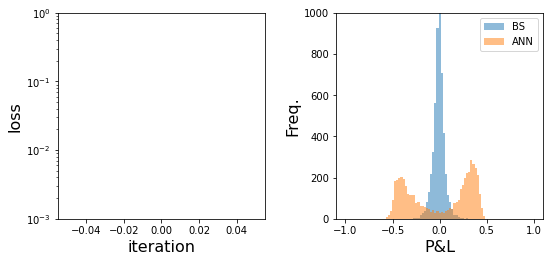

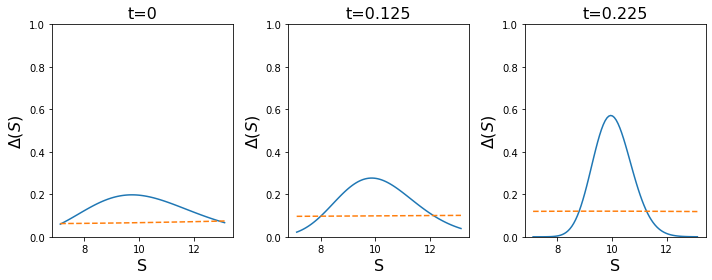

2500


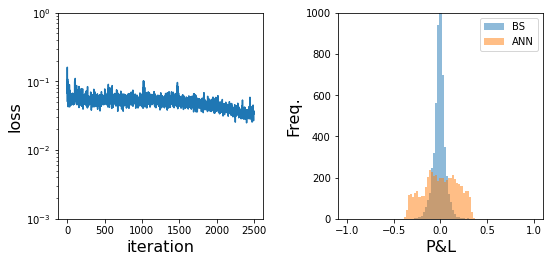

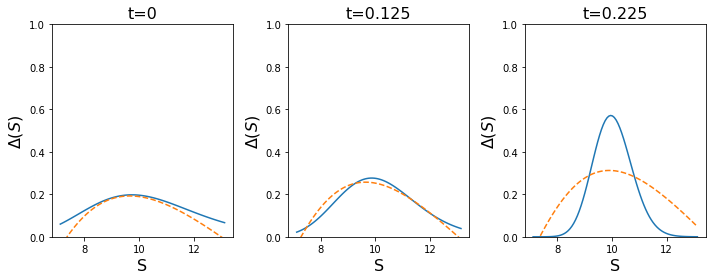

4999


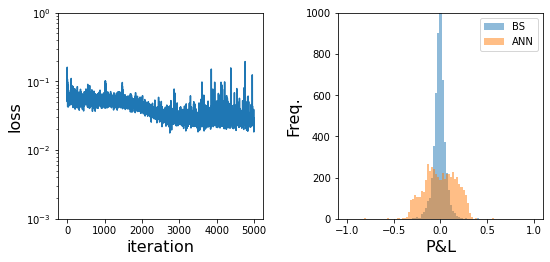

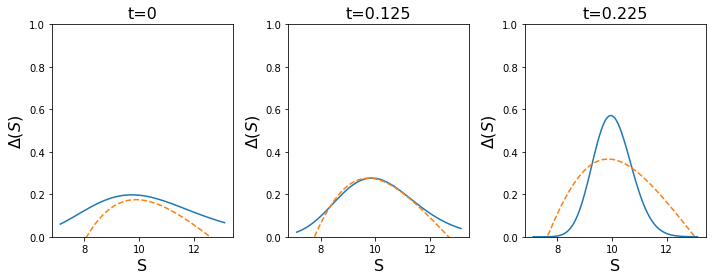

Finished Training
-0.27911884 0.2578264753403067
tensor([-0.1246], grad_fn=<CopyBackwards>) tensor([-0.0690], grad_fn=<CopyBackwards>) tensor([0.1207], grad_fn=<CopyBackwards>)
tensor(-0.0238, grad_fn=<MeanBackward0>)


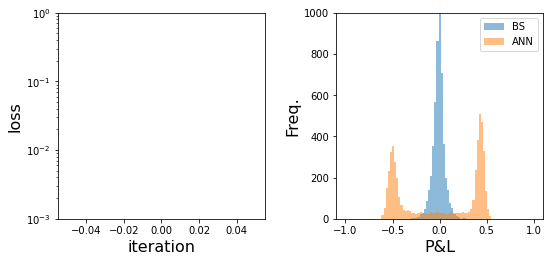

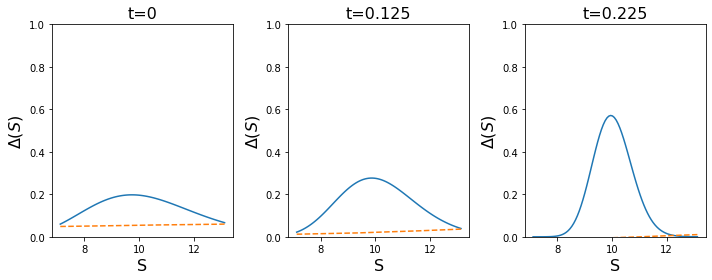

2500


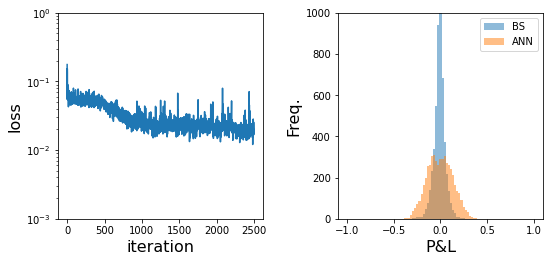

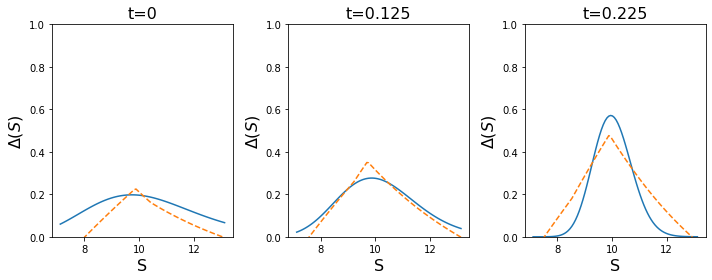

4999


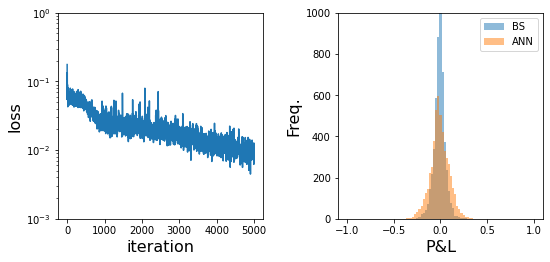

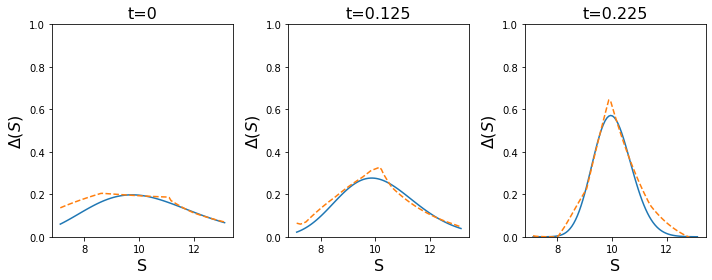

Finished Training
-0.18543315 0.16460804806322635
tensor([-0.0896], grad_fn=<CopyBackwards>) tensor([-0.0173], grad_fn=<CopyBackwards>) tensor([0.0649], grad_fn=<CopyBackwards>)
tensor(-0.0131, grad_fn=<MeanBackward0>)


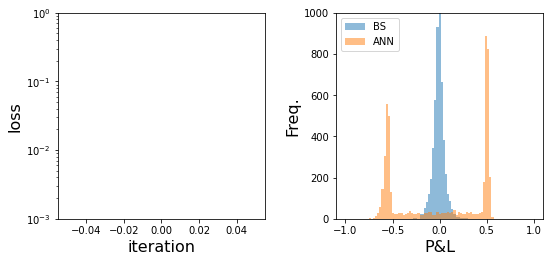

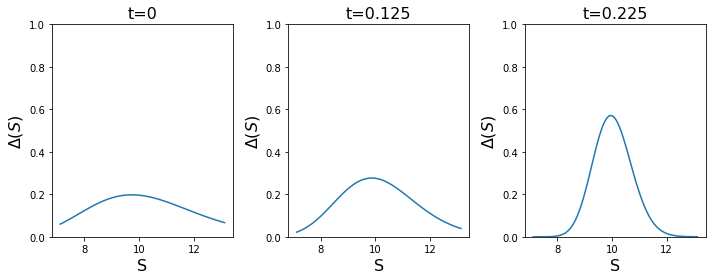

2500


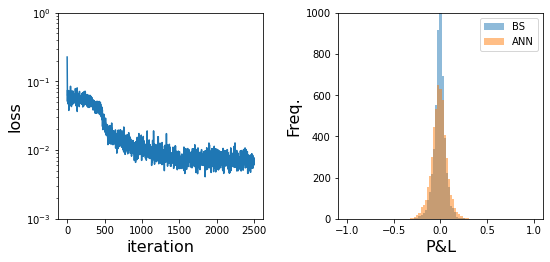

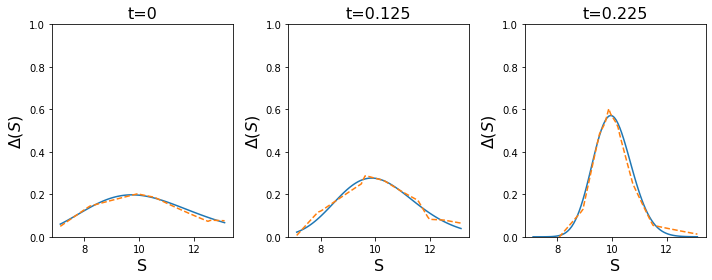

4999


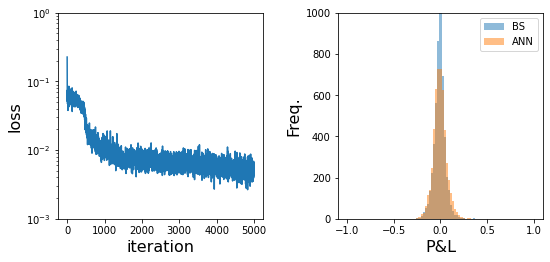

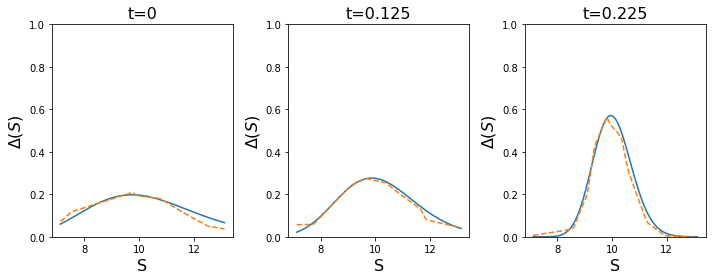

Finished Training
-0.14609256 0.12546367458163143
tensor([-0.0498], grad_fn=<CopyBackwards>) tensor([-0.0192], grad_fn=<CopyBackwards>) tensor([0.0464], grad_fn=<CopyBackwards>)
tensor(-0.0068, grad_fn=<MeanBackward0>)


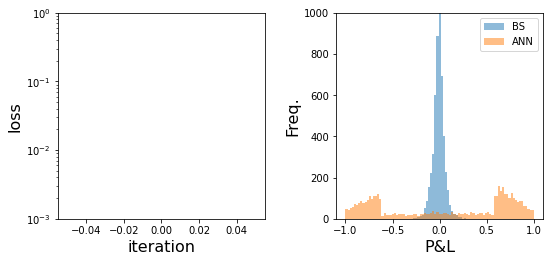

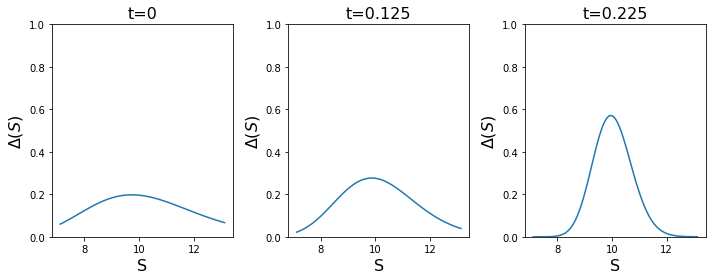

2500


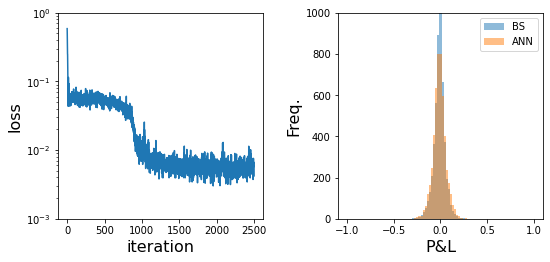

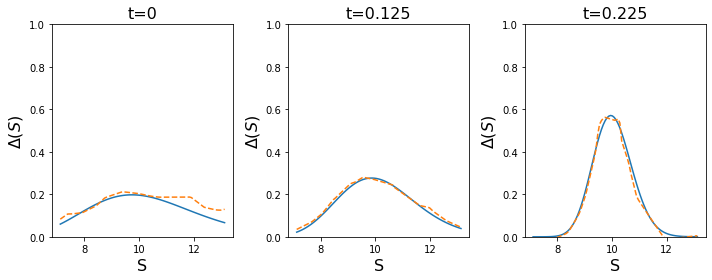

4999


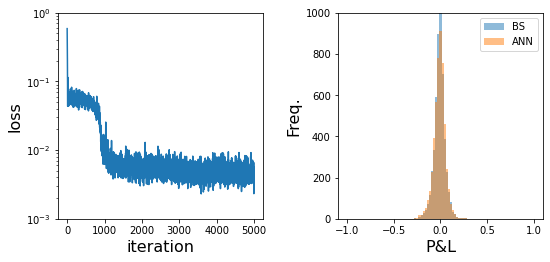

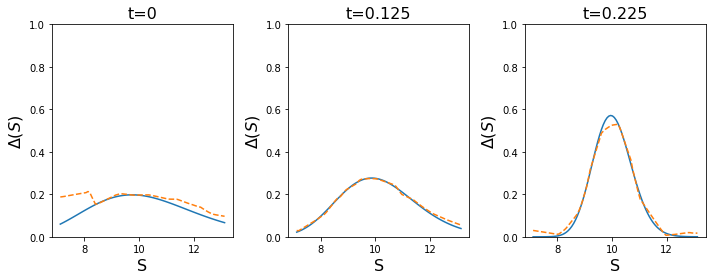

Finished Training
-0.14185855 0.1212507758826189
tensor([-0.0409], grad_fn=<CopyBackwards>) tensor([-0.0137], grad_fn=<CopyBackwards>) tensor([0.0252], grad_fn=<CopyBackwards>)
tensor(-0.0104, grad_fn=<MeanBackward0>)


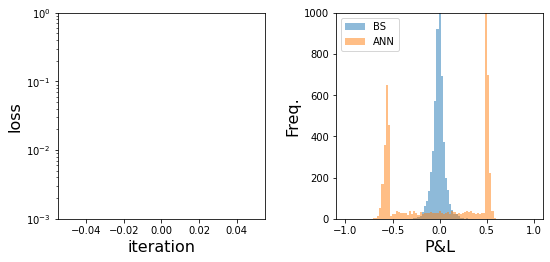

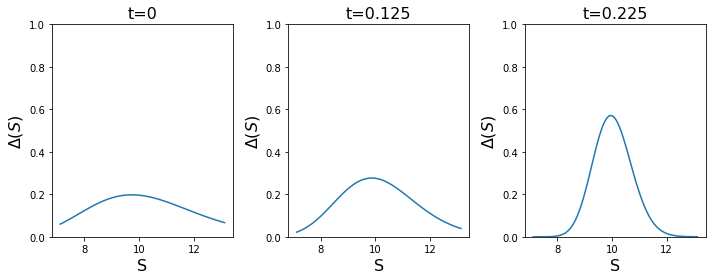

2500


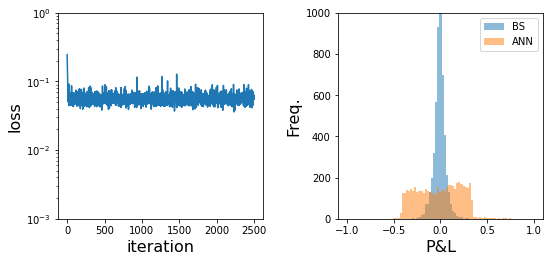

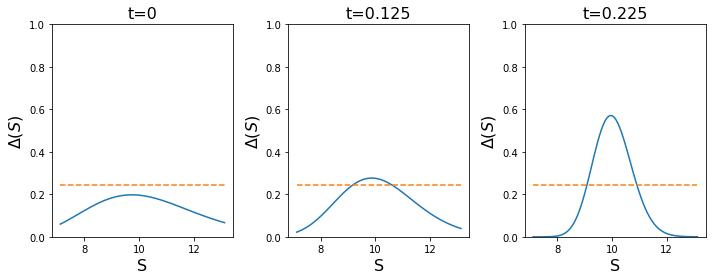

4999


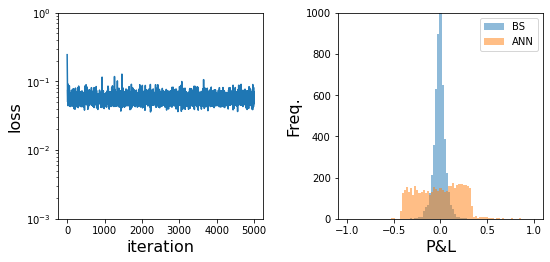

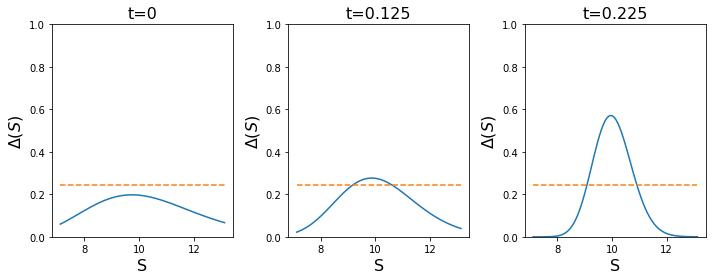

Finished Training
-0.38632903 0.36450195139547387
tensor([-0.1485], grad_fn=<CopyBackwards>) tensor([0.0132], grad_fn=<CopyBackwards>) tensor([0.1739], grad_fn=<CopyBackwards>)
tensor(-0.0041, grad_fn=<MeanBackward0>)


In [51]:
#EXPLORING ANN STRUCTURE
net = HedgeNet(90,1) # 90 nodes 1 layer
loss_hist,PnL = FitNet(net, "net_90_1")
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))

net = HedgeNet(45,2)
 # 45 nodes and 2 layers
loss_hist,PnL = FitNet(net, "net_45_2")
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))

net = HedgeNet(30,3) # 30 nodes 3 layers
loss_hist,PnL = FitNet(net, "net_30_3")
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))

net = HedgeNet(18,5) # 18 nodes and 5 layers
loss_hist,PnL = FitNet(net, "net_18_5")
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))

net = HedgeNet(9,10) # 9 nodes and 10 layers
loss_hist,PnL = FitNet(net, "net_9_10")
CVaR_10, C_star = CVaR(PnL) 
print(CVaR_10,C_star) # we get the CVaR and the adjustment price
#QUANTILES OF PNL
print(torch.quantile(PnL, 0.25, keepdim= True),torch.quantile(PnL, 0.5, keepdim=True),torch.quantile(PnL, 0.75,keepdim=True))
print(torch.mean(PnL))


In [23]:
# Role that the asset price path plays on the optimal strategy.

class GRUNet(nn.Module):
    
    def __init__(self, ni, hs, nl ):
        super(GRUNet, self).__init__()
        
        # GRU layer
        self.GRU = nn.GRU(input_size=ni, hidden_size=hs, num_layers=nl)
        
        # GRU to output
        self.prop_h_to_out = nn.Linear(hs, 1)

    def forward(self, x):
        
        # input into  GRU layer (seq, batch, feature)
        h_all, h_last = self.GRU(x)
        #_, h_last = self.GRU(x)
        
        # GRU output to output layer
        y = self.prop_h_to_out(h_all)
        
        return y
    
    def parameters(self):
        
        params = list(self.GRU.parameters())

        params += list(self.prop_h_to_out.parameters())
        
        return params

In [24]:
def Plot_Strategy(net, name=""):
    
    t = [0,0.5*T,0.9*T]
    s = np.linspace(0.75*K1,1.25*K2,90)
    plt.figure(figsize=(10,4))
    for i, t_ in enumerate(t):
        
        plt.subplot(1,3,i+1)
        plt.title('t=' + str(t_),fontsize=16)
        
        plt.plot(s, SpreadDelta(s,K1,K2, T-t_, sigma, r))
        
        x = torch.zeros(1,len(s),2)
        x[0,:,0] = 2*t_/T-1 
        x[0,:,1] = torch.tensor(2*s/s0-1)
        
        alpha = net(x)
        
        plt.plot(s, alpha.detach().numpy()[0,:,-1],'--')
        
        plt.xlabel('S', fontsize=16)
        plt.ylabel(r'$\Delta(S)$', fontsize=16)
        plt.ylim(0,1)
    
    plt.tight_layout()
    
    if not name == "":
        plt.savefig(name, dpi=300)
        
    plt.show()
    

GRUNet(
  (GRU): GRU(2, 18, num_layers=5)
  (prop_h_to_out): Linear(in_features=18, out_features=1, bias=True)
)


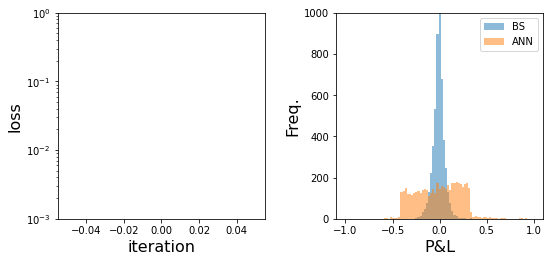

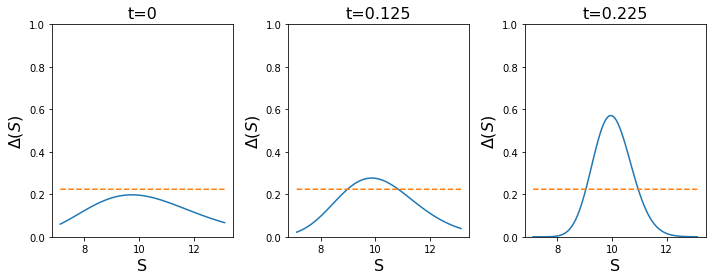

2500


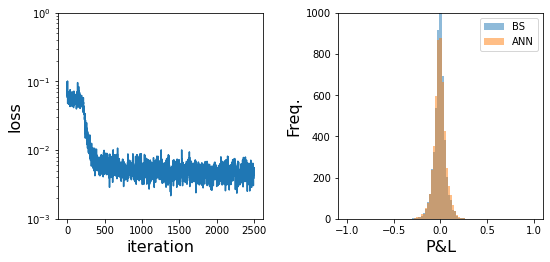

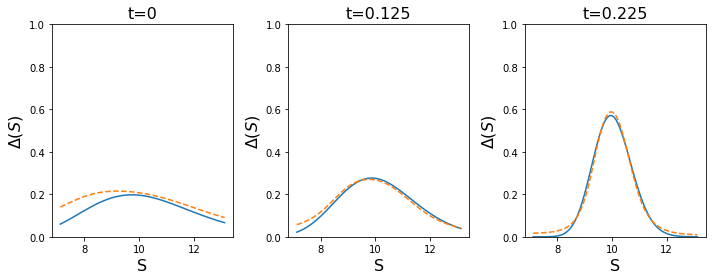

4999


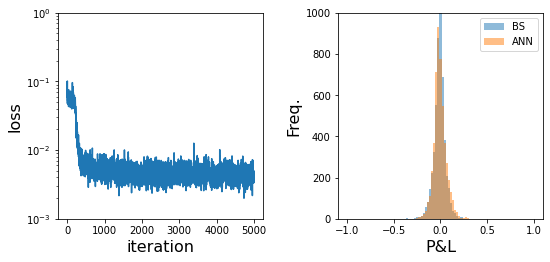

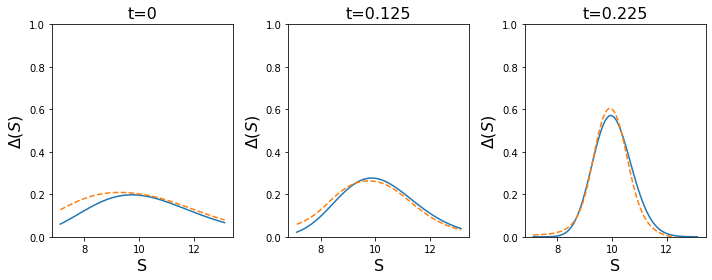

Finished Training


In [25]:
RNNnet = GRUNet(ni=2,hs=18,nl=5)
print(RNNnet)


    
RNN_hist,RNN_PnL = FitNet(RNNnet, "net_2_18_5")

# New Section

In [94]:
CVaR_10, C_star = CVaR(RNN_PnL) 
print(CVaR_10,C_star) 
print(torch.quantile(RNN_PnL, 0.25, keepdim=True),torch.quantile(RNN_PnL, 0.5, keepdim=True),torch.quantile(RNN_PnL, 0.75, keepdim=True))
print(torch.mean(RNN_PnL))


-0.13150962 0.11095346043615696
tensor([-0.0442], grad_fn=<CopyBackwards>) tensor([-0.0172], grad_fn=<CopyBackwards>) tensor([0.0115], grad_fn=<CopyBackwards>)
tensor(-0.0190, grad_fn=<MeanBackward0>)


In [95]:
C1 - C2 + C_star

0.5798329746469671